# Modelos Tradicionais (Baseline)

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx
from autogluon.timeseries.metrics.quantile import WQL

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###### Carregar e preparar o dataset

In [64]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

df.tail()

,DateTime,Date,Hour,ZipCode,ActiveEnergy(kWh),Day,Month,Year,IsWeekend,TimeOfDay,DayOfTheWeek,Season,IsHoliday,Temperature,PopulationDensity,EnergyNormalized,EnergyStandardized
3719403,2023-09-30 23:00:00,2023-09-30,23,1685,3588.766159,30,9,2023,1,Noite,Sábado,Outono,0,21.8,5455.23,0.023778,-0.562608
3719404,2023-09-30 23:00:00,2023-09-30,23,3740,1849.719996,30,9,2023,1,Noite,Sábado,Outono,0,22.4,2788.79,0.012252,-0.713159
3719405,2023-09-30 23:00:00,2023-09-30,23,3750,12433.094481,30,9,2023,1,Noite,Sábado,Outono,0,22.4,2788.79,0.082397,0.203054
3719406,2023-09-30 23:00:00,2023-09-30,23,3680,2393.029205,30,9,2023,1,Noite,Sábado,Outono,0,20.2,196.31,0.015853,-0.666124
3719407,2023-09-30 23:00:00,2023-09-30,23,8970,720.206910,30,9,2023,1,Noite,Sábado,Outono,0,22.5,333.82,0.004766,-0.810942


In [3]:
# Filtrar CP 2840 e ordenar
df_cp = df[df["ZipCode"] == "2840"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Colocar o item_id obrigatório para o AutoGluon
df_cp["item_id"] = "2840"
df_cp.set_index("DateTime", inplace=True)

###### Separar treino e teste (até 29-09) e teste (30-09)

In [13]:
treino = df_cp.loc[:'2023-09-29 23:00'].copy() # Treino até 29-09-2023 23:00
teste = df_cp.loc['2023-09-30 00:00':'2023-09-30 23:00'].copy() # Teste apenas para validação visual

treino_reset = treino.reset_index() # Reset index para usar com AutoGluon

###### Criar TimeSeriesDataFrame

In [16]:
train_data = TimeSeriesDataFrame.from_data_frame(
    treino_reset[["item_id", "DateTime", "EnergyNormalized"]],
    id_column="item_id",
    timestamp_column="DateTime"
)

# 📊ARIMA

###### importar modelo

In [ ]:
model_path = "AutogluonModels/ag-20250417_182601" # Caminho onde o modelo foi guardado

predictor = TimeSeriesPredictor.load(model_path) # Carregar o modelo

###### treinar

In [47]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    hyperparameters={"ARIMA": {}},  # apenas ARIMA
    time_limit=300
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_185656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.20 GB / 15.93 GB (26.3%)
Disk Space Avail:   717.29 GB / 931.46 GB (77.0%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'h'

###### prever

In [48]:
forecast = predictor.predict(train_data)
forecast_values = forecast.loc["2840"]

# Lidar com possíveis múltiplas colunas
if isinstance(forecast_values, pd.DataFrame):
    y_pred = forecast_values.iloc[:, 0].values
else:
    y_pred = forecast_values.values

Model not specified in predict, will default to the model with the best validation score: ARIMA


###### Preparar dados reais

In [49]:
real_values = teste["EnergyNormalized"]
y_true = real_values.values

###### grafico

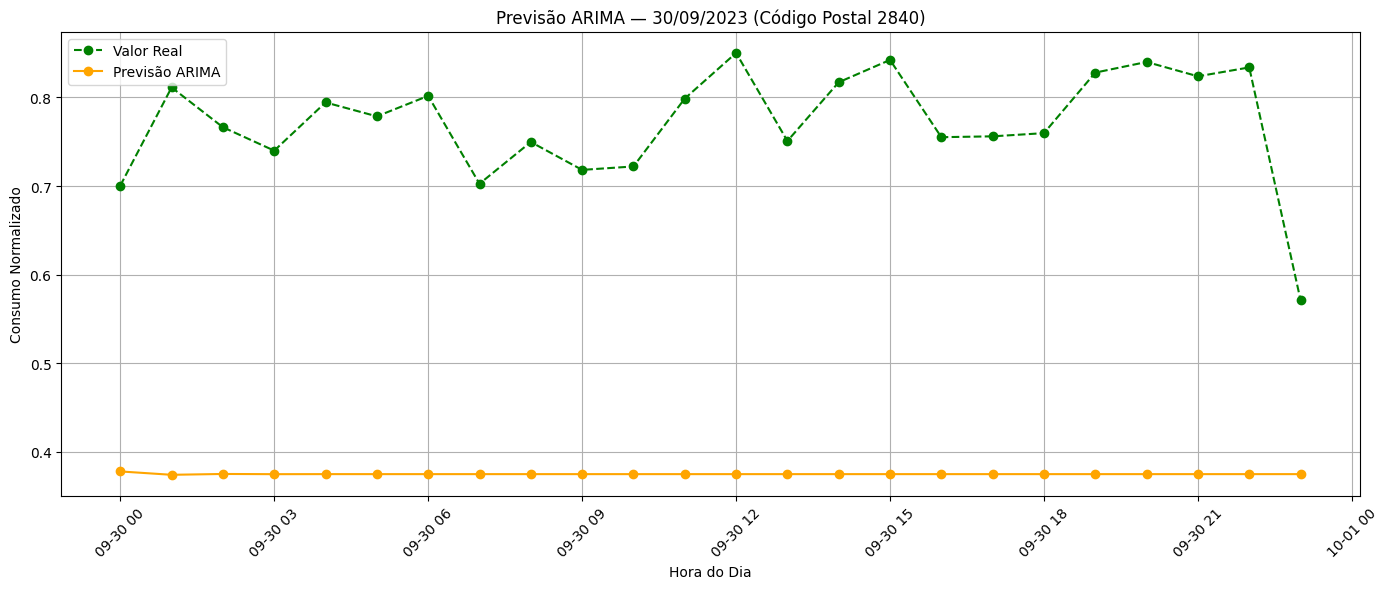

In [50]:
plt.figure(figsize=(14, 6))

plt.plot(real_values.index, real_values.values, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(forecast_values.index, forecast_values.iloc[:, 0] if isinstance(forecast_values, pd.DataFrame) else forecast_values,
         label="Previsão ARIMA", marker='o', color='orange')

plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 2840)")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

### 🧠 Interpretação geral
ARIMA não é suficiente para este tipo de série com: <br/>
    - Padrões horários<br/>
    - Picos de consumo previsíveis<br/>
    - Influência de variáveis exógenas (ex: temperatura, dia da semana)

In [51]:
# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE: 0.3965
📊 MSE: 0.1609
📊 RMSE: 0.4012
📊 MAPE: 51.05%


### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                            |
|--------------------------------------------|--------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.3965 | Em média, o erro absoluto foi de ~0.396 unidades normalizadas.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.1609 | Erros maiores são penalizados; aqui está relativamente moderado.                                                                                                                      |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.4012 | Raiz do MSE, dá uma ideia intuitiva da variação média do erro.                                                                                                                             |
| **MAPE** (Erro Percentual Absoluto Médio)  | 51.05% | O erro percentual médio é relativamente elevado (acima de 30% já é preocupante).                                                                                           |

# 📊XARIMA com variáveis exógenas

In [27]:
# --- 1) Carrega e formata o TSDF com Temperature como known covariate ----
df = pd.read_parquet("./datasets/consumo_eredes_normalizado.parquet")

# Filtrar CP 2840 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# 1.2. Construa o TimeSeriesDataFrame
# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# covariáveis conhecidas
known_covs = ["Hour", "DayOfTheWeek", "Month", "Season", "IsWeekend", "IsHoliday", "Temperature"]

# Separe train/test
train_data, test_data = ts_df.train_test_split(prediction_length=24)

In [3]:
# Importar um modelo guardado
predictor_xarima = TimeSeriesPredictor.load("./predicts/XARIMA/modelo/")

In [28]:
# --- 2) Treina ARIMA+CAT com Temperature como exógena ----
predictor_xarima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "covariate_regressor": "CAT",
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
)

predictor_xarima.save() # Exportar o modelo

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       5.36 GB / 15.93 GB (33.7%)
Disk Space Avail:   717.15 GB / 931.46 GB (77.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'covariate_regressor': 'CAT',
                                    'target_scaler': 'standard'}},
 'known_covariates_names': ['Hour',
                            'DayOfTheWeek',
                            'Month',
                            'Season',
                            'IsWeekend',
                            'IsHoliday',
                  

In [32]:
# --- 3) Monte o DataFrame de covariáveis FUTURAS (próximas 24h) ---
last_time = train_data.index.get_level_values("timestamp").max()
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

# 2) fatie o df_cp nessas datas:
df_future_covs = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 3) montar o TimeSeriesDataFrame só com essas covariáveis:
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    df_future_covs,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

In [33]:
# --- 4) Preveja passando essas covariáveis ----
preds = predictor_xarima.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Defina y_pred e y_true para o horizonte de 24h:
#  use o quantil 0.5 como previsão pontual
y_pred = preds["0.5"]
#  extraia os 24 valores reais normalizados de EnergyNormalized do test_data
y_true = test_data["EnergyNormalized"].loc[preds.index]

# --- 5) Avalie no hold‑out se quiser ----
metrics = predictor_xarima.evaluate(test_data)
print("WQL hold‑out com Temperature exógena:", metrics["WQL"])

Model not specified in predict, will default to the model with the best validation score: ARIMA
Model not specified in predict, will default to the model with the best validation score: ARIMA


WQL hold‑out com Temperature exógena: -0.08075431151168086


In [34]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# 1) Erros elementares
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# 2) Métricas ponto-estimadas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()

# 3) Margem de erro de 95% para cada métrica
z = 1.96  # para 95% CI
# Função auxiliar que, dada a lista de erros elementares e a métrica 'mean', retorna margem de erro: z * (std(errs) / sqrt(n))
def margin_of_error(errs):
    return z * (np.std(errs, ddof=1) / np.sqrt(n))

moe_MAE  = margin_of_error(abs_errs)
moe_MSE  = margin_of_error(sq_errs)
# Para RMSE, pode‐se usar delta‐method: se RMSE = sqrt(MSE),
# então var(RMSE) ≈ var(MSE) / (4*MSE). Para simplicidade aproximamos:
moe_RMSE = moe_MSE / (2 * RMSE)
moe_MAPE = margin_of_error(pct_errs)

# 4) Consolide num DataFrame
df_metrics = pd.DataFrame({
    "Métrica":     ["MAE", "MSE", "RMSE", "MAPE (%)"],
    "Valor":       [MAE,  MSE,   RMSE,   MAPE]
})

print(df_metrics)

    Métrica     Valor
0       MAE  0.002807
1       MSE  0.000014
2      RMSE  0.003680
3  MAPE (%)  6.001837


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                       |
|----------------------------------------------|---------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00281 | Em média, a previsão “acerta” o consumo com um desvio de 0,281% do valor normalizado — ou seja, de cada 100 kWh reais, erra em torno de 0,281 kWh.                  |
| **MSE** (Erro Quadrático Médio)              | 0.00014 | Bom indicador de erros grandes: eleva o erro ao quadrado. Como é tão pequeno, significa que praticamente não houve previsões muito longe da realidade.              |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00368 | É o “desvio médio quadrático” e também está em unidades normalizadas. Significa um erro típico de 0,368% do consumo real — ou cerca de 0,368 kWh para cada 100 kWh. |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.00%   | Mostra o erro em termos percentuais. Em média erra 6% do valor real, ou seja, se forem 100 kWh de consumo, a previsão vai ficar em média 6 kWh acima ou abaixo.     |

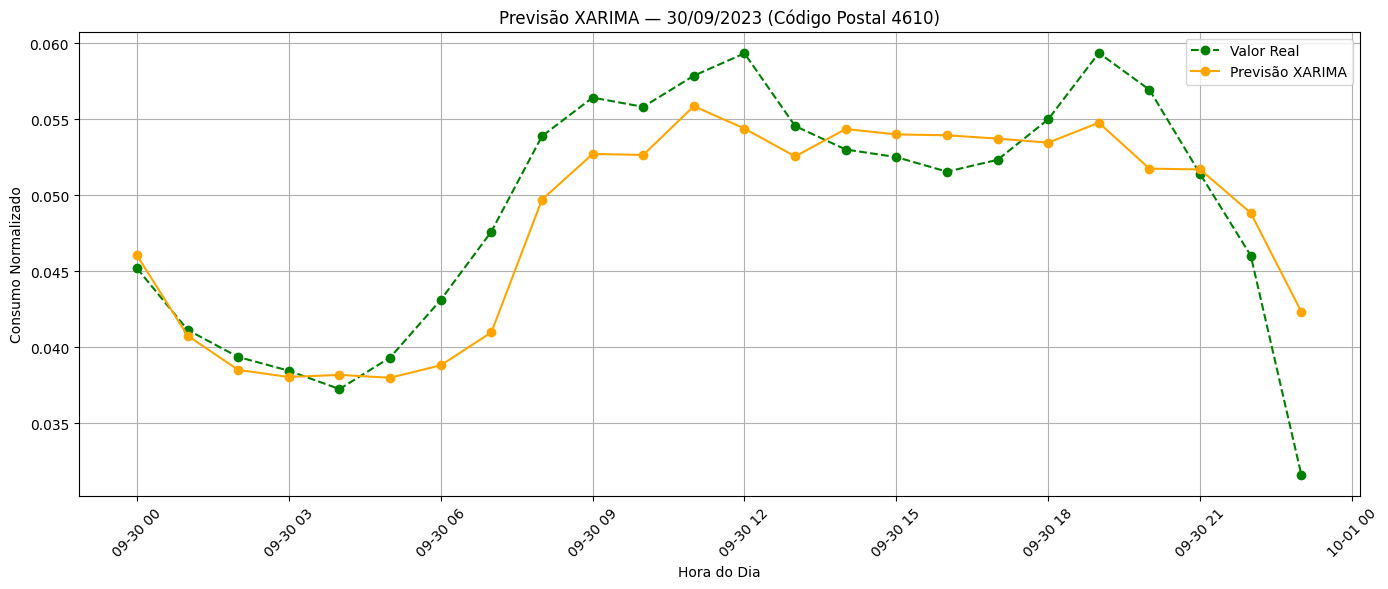

In [35]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão XARIMA", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão XARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()